In [74]:
import xarray as xr
import numpy as np
# import pandas as pd
from matplotlib import pyplot as plt
import glob
from matplotlib import rcParams
rcParams["font.size"] = 13

In [75]:
# from netCDF4 import Dataset
# import os
# folder = r'C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\PEARL FTIR O3'
# files = glob.glob(folder + r'\*.hdf')
# output_folder = os.path.join(folder, 'netcdf_out')
# os.makedirs(output_folder, exist_ok=True)


# for file in files:
#     with Dataset(file, "r") as f:
#         output_file = os.path.basename(file) + ".nc"
#         cdf_file = os.path.join(output_folder, output_file)
#         with Dataset(cdf_file, "w", format="NETCDF4") as dst:
#             for attr in f.ncattrs():
#                 dst.setncattr(attr, f.getncattr(attr))

#             idx_len = int(str(list(f.dimensions.values())[0]).split()[-1])
#             dst.createDimension("altitude2", 47)
#             dst.createDimension("altitude1", 47)
#             dst.createDimension("single", 1)
#             dst.createDimension("source", 103)
#             dst.createDimension("two", 2)
#             dst.createDimension("idx", idx_len)
#             dst.createDimension("DATETIME", idx_len)

#             altitude1_var = dst.createVariable("altitude1", "i4", ("altitude1",))
#             altitude1_var[:] = f["ALTITUDE"][:]

#             vars = list(f.variables)
#             for var in vars:
#                 cdf_dims = []
#                 dims = f[var].dimensions
#                 if len(dims) > 2:
#                     cdf_dims.append("idx")
#                     cdf_dims.append("altitude1")
#                     cdf_dims.append("altitude2")
#                 else:
#                     for dim in dims:
#                         dim_len = len(f.dimensions[dim])
#                         if dim_len == idx_len:        
#                             cdf_dims.append("idx")
#                         elif dim_len == 2:
#                             cdf_dims.append("two")
#                         elif dim_len == 1:
#                             cdf_dims.append("single")
#                         elif dim_len == 103:
#                             cdf_dims.append("source")
#                         else:
#                             cdf_dims.append("altitude1")
#                 cdf_var = dst.createVariable(var, f[var].datatype, tuple(cdf_dims))
#                 for attr in f[var].ncattrs():
#                     if attr == "_FillValue":
#                         continue
#                     cdf_var.setncattr(attr, f[var].getncattr(attr))
#                 cdf_var[:] = f[var][:]

#             dst["DATETIME"].setncattr("units", "days since 2000-01-01 00:00:00")
#             dst["DATETIME"].setncattr("standard_name", "time")
#             dst["DATETIME"].setncattr("calendar", "standard")

In [76]:
from file_paths import PARENT_FOLDER
directory = PARENT_FOLDER + r'\PEARL_FTIR\netcdf_out'

path = directory + r'\*.nc'

nc_list = glob.glob(path)

f = xr.open_mfdataset(
    nc_list,
    combine="nested",
    concat_dim="idx",
    engine="netcdf4",
    decode_cf=True
)

In [77]:
f = f.swap_dims({"idx": "DATETIME"})
f = f.sortby("DATETIME")

In [78]:
midpoints = np.mean(f["ALTITUDE.BOUNDARIES"][0].values, axis=0)
f = f.assign_coords(altitude1=('altitude1', midpoints))
f = f.sortby("altitude1")

In [ ]:
vmr_apriori = f["O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR_APRIORI"].values
OG_AVKS = np.flip(f["O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR_AVK"].values, axis = 2)
AVKS = np.empty(OG_AVKS.shape)
for i in range(OG_AVKS.shape[0]):
    og_avk_measurement = OG_AVKS[i]
    apriori_measurement = np.tile(vmr_apriori[i], (47, 1))

    avk_row = og_avk_measurement * (apriori_measurement / apriori_measurement.T)
    
    AVKS[i,:,:] = avk_row

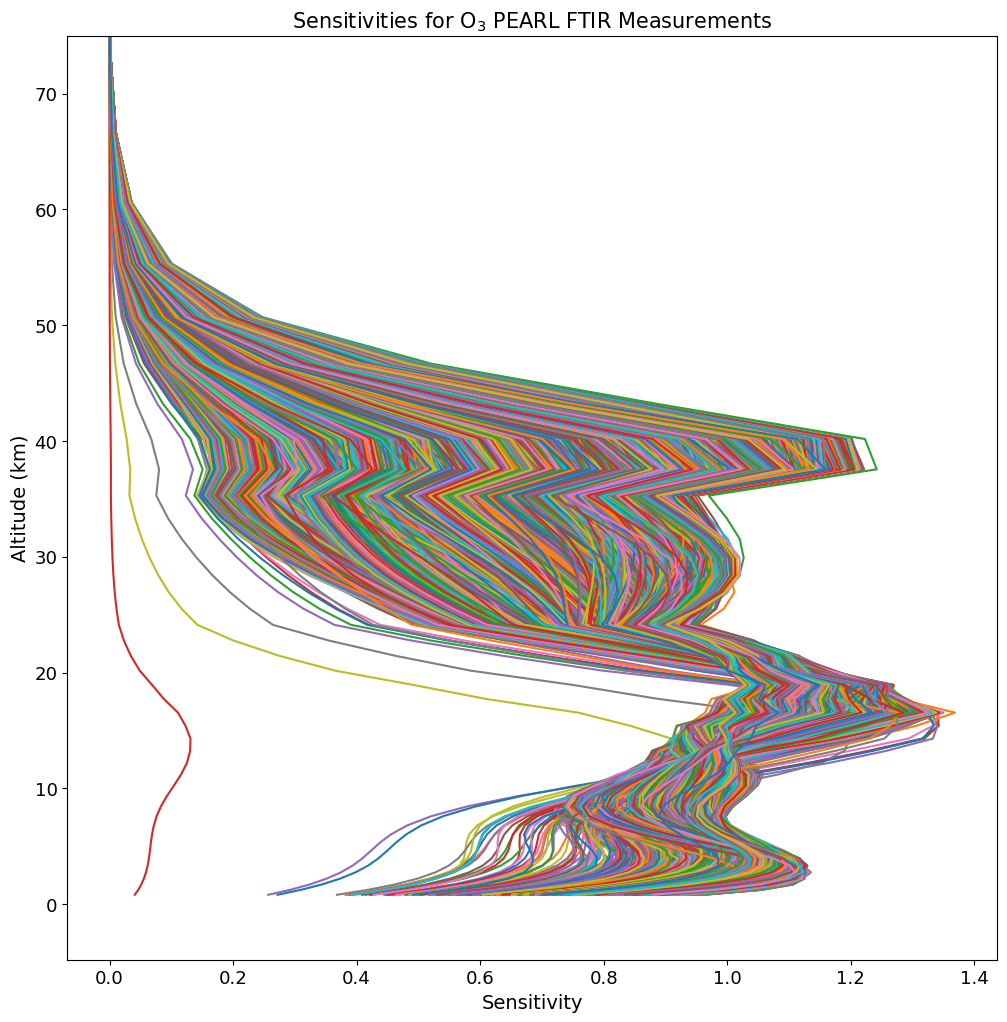

In [118]:
plt.figure(figsize=(12, 12))
for avk in AVKS:
    plt.plot(np.nansum(avk, axis=1), f["altitude1"].values)

plt.ylim(top = 75)
plt.xlabel("Sensitivity", fontsize = 14)
plt.ylabel("Altitude (km)", fontsize = 14)
plt.title("Sensitivities for O$_3$ PEARL FTIR Measurements", fontsize = 15)

fig = plt.gcf()
axes = plt.gca()
title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

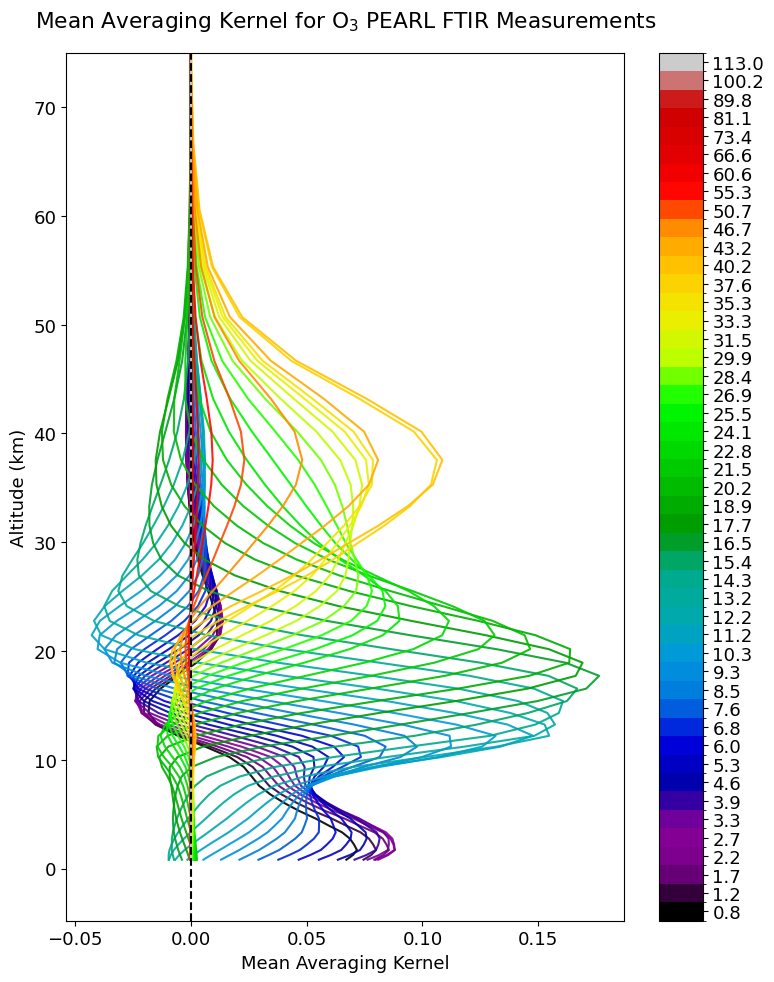

In [117]:
mean_avk = np.nanmean(AVKS, axis = 0)
alts     = f["altitude1"].values

fig, ax = plt.subplots(figsize=(8, 10))

cmap = plt.get_cmap("nipy_spectral", 47)
colors = cmap(np.arange(47))

for i in range(mean_avk.shape[0]):
    plt.plot(mean_avk[i, :], alts, color=colors[i], alpha = 0.9)

import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
bounds = np.unique(f["ALTITUDE.BOUNDARIES"][0].values.flatten())
lcmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, lcmap.N)

sm = mpl.cm.ScalarMappable(cmap=lcmap, norm=norm)

cbar = fig.colorbar(sm, ax=ax,
                    boundaries=bounds,
                    ticks=alts,
                    spacing='uniform')

ymin, ymax = plt.ylim()
plt.plot([0, 0], [ymin, ymax], color='black', ls='dashed')
plt.ylim(ymin, 75)
ax.set_xlabel("Mean Averaging Kernel")
ax.set_ylabel("Altitude (km)")
ax.set_title("Mean Averaging Kernel for O$_3$ PEARL FTIR Measurements", y = 1.02)
fig.tight_layout()

title = ax.get_title()
fig.savefig(title, bbox_inches="tight")

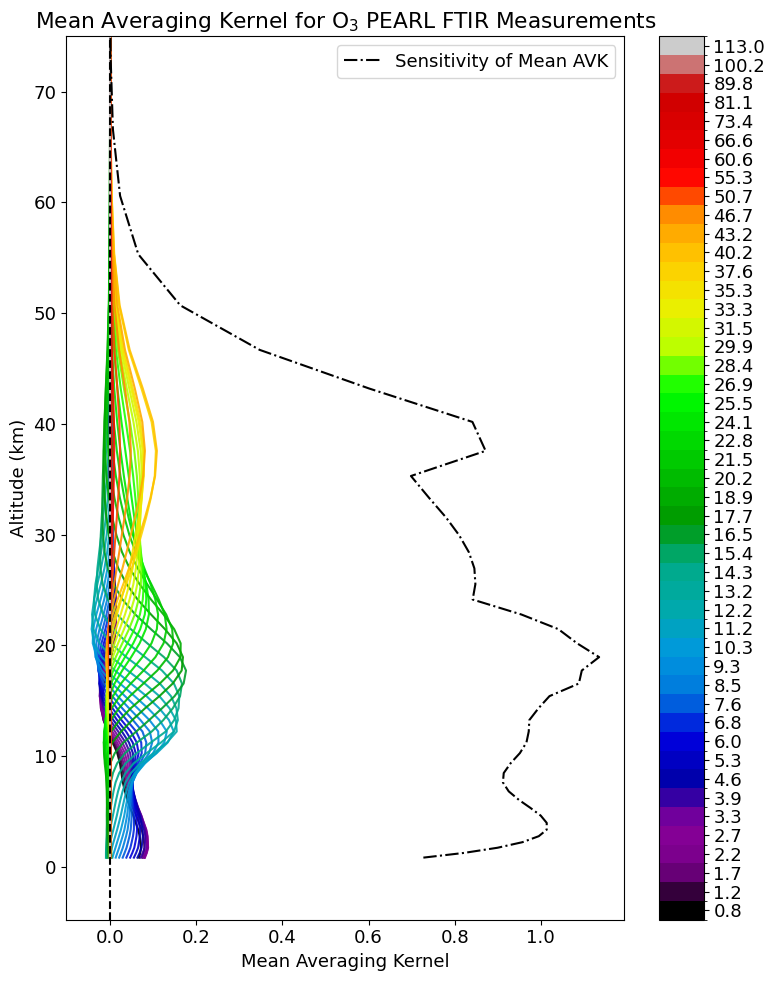

In [116]:
mean_avk = np.nanmean(AVKS, axis = 0)
alts     = f["altitude1"].values

fig, ax = plt.subplots(figsize=(8, 10))

cmap = plt.get_cmap("nipy_spectral", 47)
colors = cmap(np.arange(47))

for i in range(mean_avk.shape[0]):
    plt.plot(mean_avk[i, :], alts, color=colors[i], alpha = 0.9)

import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
bounds = np.unique(f["ALTITUDE.BOUNDARIES"][0].values.flatten())
lcmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, lcmap.N)

sm = mpl.cm.ScalarMappable(cmap=lcmap, norm=norm)

cbar = fig.colorbar(sm, ax=ax,
                    boundaries=bounds,
                    ticks=alts,
                    spacing='uniform')          

ymin, ymax = plt.ylim()
plt.plot([0, 0], [ymin, ymax], color='black', ls='dashed')
plt.ylim(ymin, 75)

plt.plot(np.nansum(mean_avk, axis = 1), alts, color='black', ls='-.', label = "Sensitivity of Mean AVK")
plt.legend()

ax.set_xlabel("Mean Averaging Kernel")
ax.set_ylabel("Altitude (km)")
ax.set_title("Mean Averaging Kernel for O$_3$ PEARL FTIR Measurements")
fig.tight_layout()

title = ax.get_title()
fig.savefig(title + "(with sensitivity)", bbox_inches="tight")

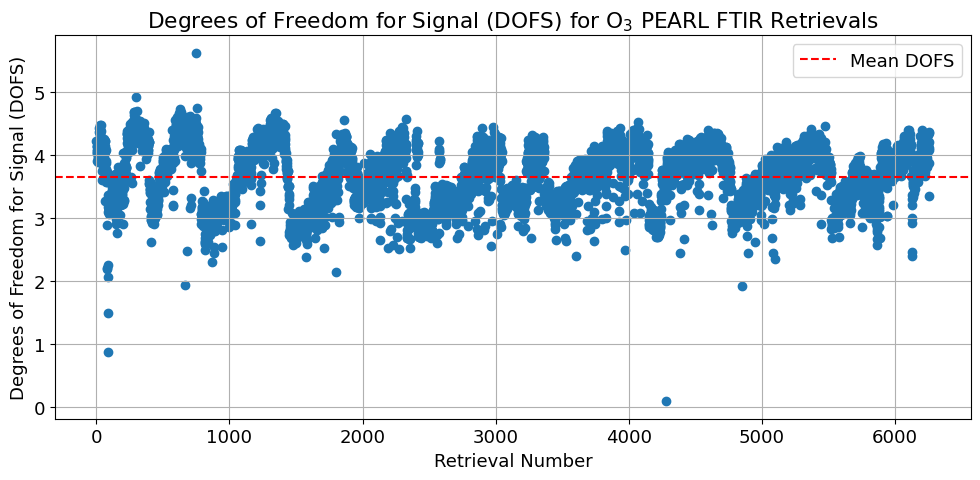

In [ ]:
diag_sums = [np.trace(avk) for avk in AVKS]

plt.figure(figsize=(10, 5))
plt.scatter(range(len(diag_sums)), diag_sums)
plt.title("Degrees of Freedom for Signal (DOFS) for O$_3$ PEARL FTIR Retrievals")
plt.xlabel("Retrieval Number")
plt.ylabel("Degrees of Freedom for Signal (DOFS)")
plt.grid(True)
plt.tight_layout()

mean_dofs = np.nanmean(diag_sums)
fig = plt.gcf()
axes = plt.gca()

plt.gca().axhline(mean_dofs, color = "red", linestyle = "dashed", label = "Mean DOFS")
plt.legend()


title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [21]:
O3_vmr = f["O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR"] * 1e-6
O3_times = O3_vmr.sel(DATETIME = slice("2006-01-01", "2020-12-31"))
latitude = 80.05
longitude = -86.42
altitude1 = O3_times["altitude1"].values

In [22]:
temperature = f["TEMPERATURE_INDEPENDENT"]
pressure = f["PRESSURE_INDEPENDENT"] * 100
k = 1.380649e-23
O3_density = O3_vmr * pressure/(k * temperature)
# vmr - mol o3/mol air
# mol o3/mol air * mol air/vol air = num density = vmr * mol air/vol air = mol o3/vol air in molecules/m^3
# mol air/vol air = N/V
# PV = NkT
# N/V = P/kT
# num density = vmr * N/V = vmr * P/kT
# column = num density*altitude diff

C:\Users\salla\AppData\Local\Temp\ipykernel_23144\2609900276.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(has_fig.axes.flat):


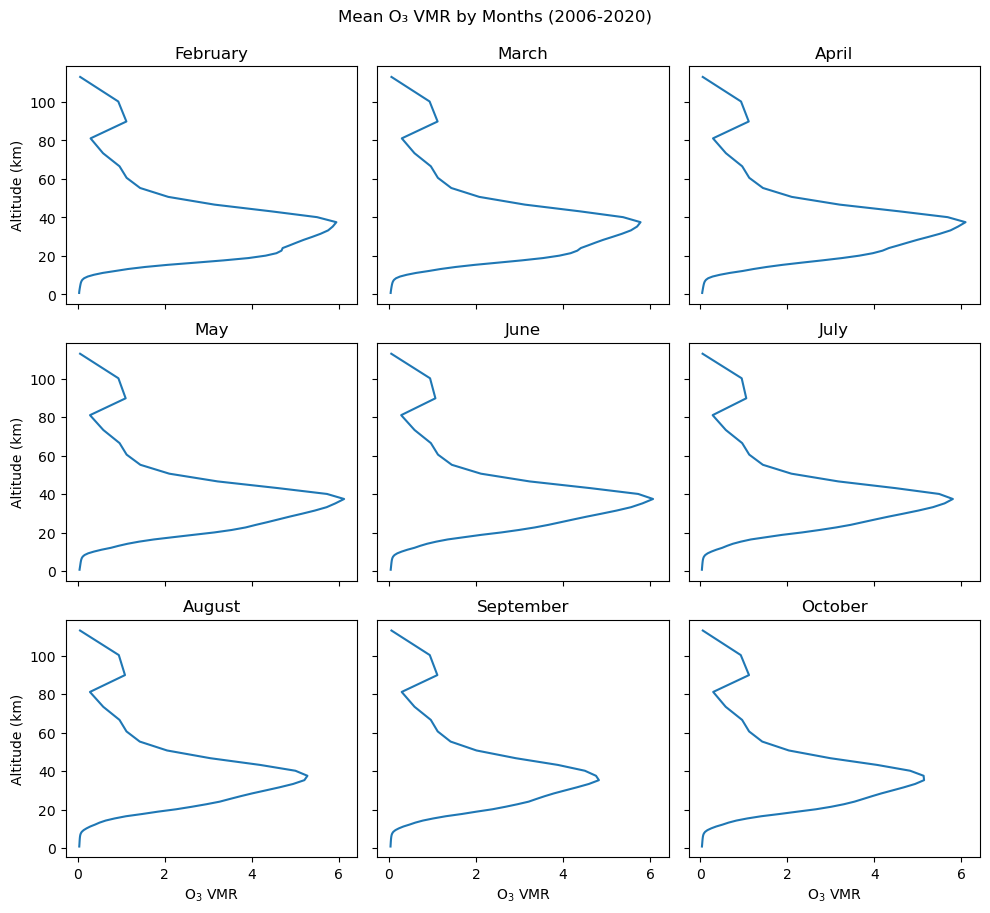

In [31]:
has_fig = (((O3_times).groupby("DATETIME.month").mean(dim  = "DATETIME") * 10**6)).plot(col = "month", col_wrap = 3, y = "altitude1")
has_fig.fig.axes[0].set_ylabel("Altitude (km)")
has_fig.fig.axes[3].set_ylabel("Altitude (km)")
has_fig.fig.axes[6].set_ylabel("Altitude (km)")
has_fig.fig.axes[6].set_xlabel("O$_3$ VMR")
has_fig.fig.axes[7].set_xlabel("O$_3$ VMR")
has_fig.fig.axes[8].set_xlabel("O$_3$ VMR")

plt.suptitle("Mean O₃ VMR by Months (2006-2020)", y = 1.025)

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for i, ax in enumerate(has_fig.axes.flat):
    ax.set_title(month_names[i + 1])

title = has_fig.fig._suptitle.get_text()
has_fig.fig.savefig(title, bbox_inches="tight")

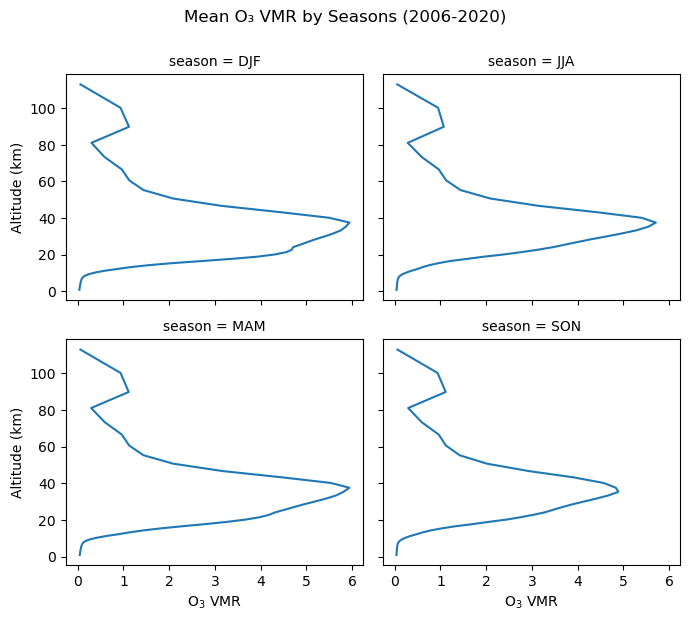

In [24]:
has_fig = (O3_times.groupby("DATETIME.season").mean(dim  = "DATETIME") * 10**6).plot(col = "season", col_wrap = 2, y = "altitude1")
has_fig.fig.axes[0].set_ylabel("Altitude (km)")
has_fig.fig.axes[2].set_ylabel("Altitude (km)")
has_fig.fig.axes[2].set_xlabel("O$_3$ VMR")
has_fig.fig.axes[3].set_xlabel("O$_3$ VMR")

plt.suptitle("Mean O₃ VMR by Seasons (2006-2020)", y = 1.05)

title = has_fig.fig._suptitle.get_text()
has_fig.fig.savefig(title, bbox_inches="tight")

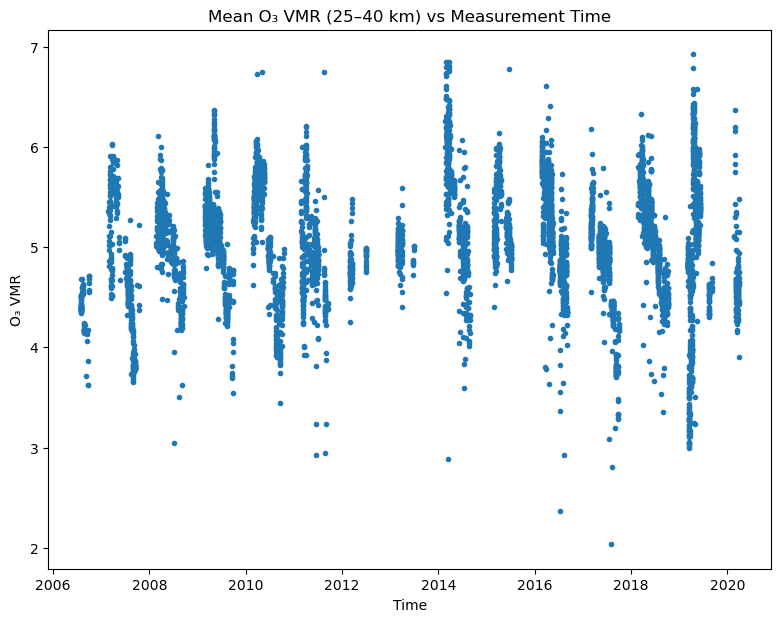

In [26]:
(O3_times.sel(altitude1 = slice(25, 40)).mean(dim = "altitude1") * 10**6).plot(marker = ".", linestyle = "None", size = 7)

plt.ylabel("O₃ VMR")
plt.xlabel("Time")
plt.title("Mean O₃ VMR (25–40 km) vs Measurement Time")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

c:\Users\salla\anaconda3\Lib\site-packages\xarray\groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


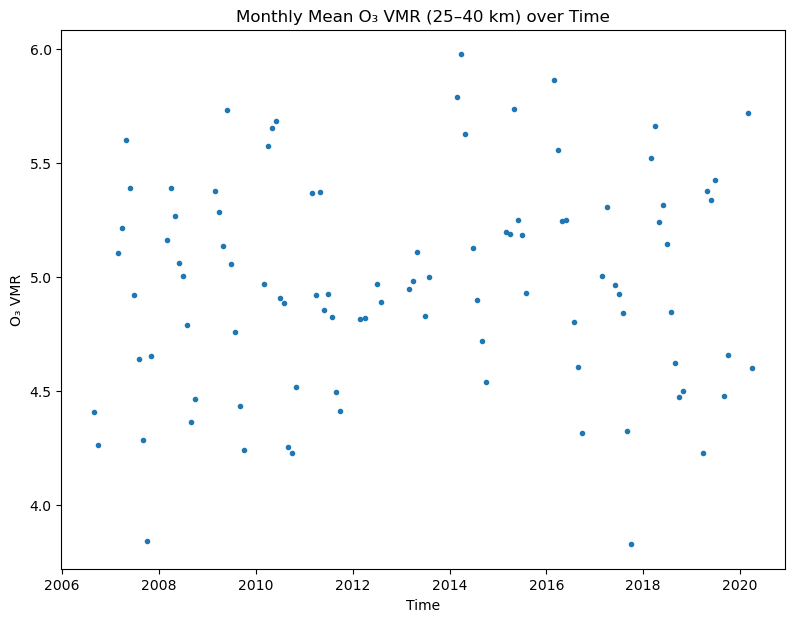

In [27]:
(O3_times.sel(altitude1 = slice(25, 40)).resample(DATETIME = "1M").mean(dim = ["altitude1", "DATETIME"]) * 10**6).plot(marker = ".", linestyle = "None", size = 7)

plt.ylabel("O₃ VMR")
plt.xlabel("Time")
plt.title("Monthly Mean O₃ VMR (25–40 km) over Time")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

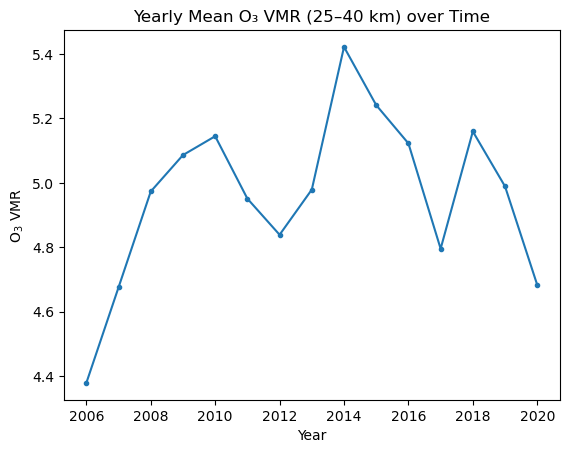

In [28]:
has_fig = (O3_times.sel(altitude1 = slice(25, 40)).groupby("DATETIME.year").mean(dim = ["altitude1", "DATETIME"]) * 10**6).plot(marker = ".")
plt.xlabel("Year")
plt.ylabel("O$_3$ VMR")
plt.title("Yearly Mean O₃ VMR (25–40 km) over Time")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

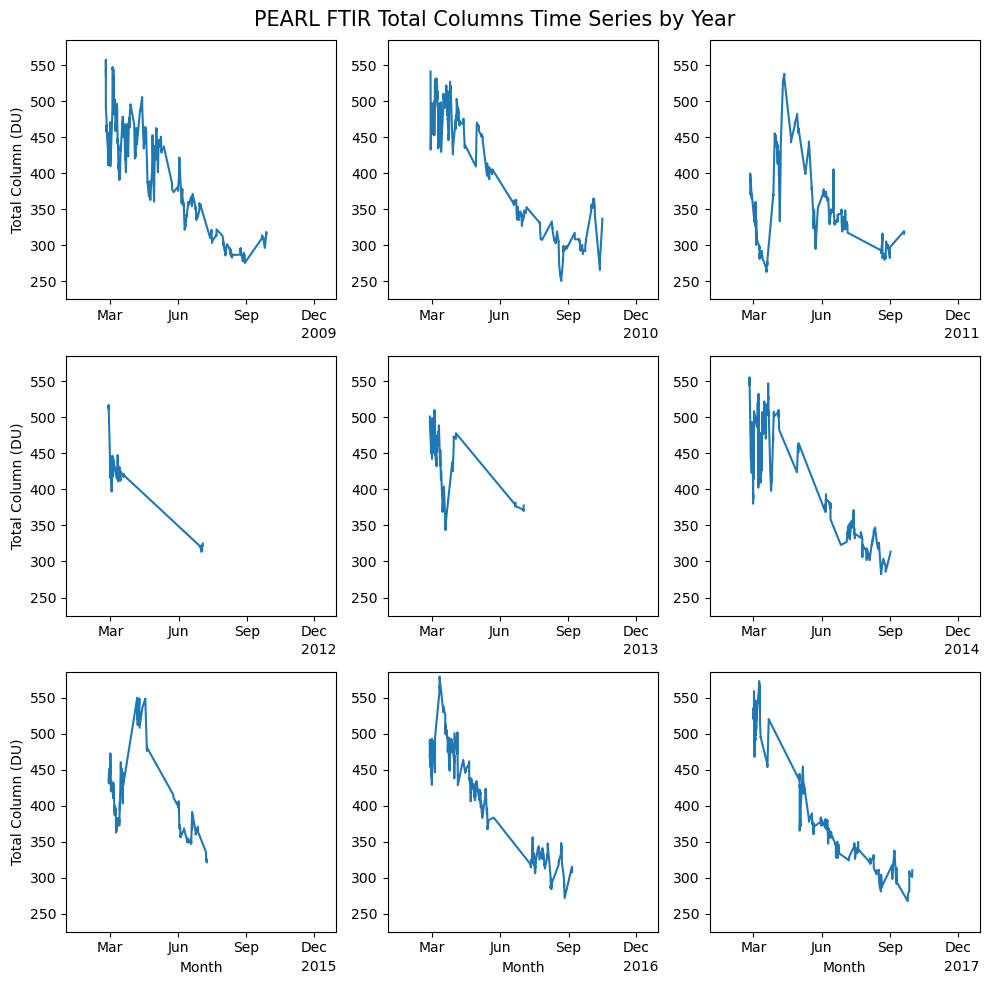

In [30]:
import matplotlib.dates as mdates
fig, axes = plt.subplots(3,3, figsize = (10,10))
years = [str(year) for year in range(2009, 2018)]
for i, year in enumerate(years):
    flat_axes = axes.flatten()
    ax = flat_axes[i]
    data = O3_partial_column_DU.sel(DATETIME = slice(year + "-01-01", year + "-12-31"))
    data.plot(ax = ax)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3, 6, 9, 12)))
    ax.set_xlim(np.datetime64(year + '-01-01', 'ns'), np.datetime64(year + '-12-31', 'ns'))
    ax.set_ylim(225, 585)
    if ax in flat_axes[-3:]:
        ax.set_xlabel("Month")
    else:
        ax.set_xlabel("")
    if ax in flat_axes[::3]:
        ax.set_ylabel("Total Column (DU)")
    else:
        ax.set_ylabel("")

plt.suptitle(
    "PEARL FTIR Total Columns Time Series by Year", 
    fontsize=15,
    y=0.98
)

plt.tight_layout()

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")